# Plotting spatial results from Pastas models for different wells in Bangkok, Thailand.

- A well nest may have 1-4 wells
- Outputs: Spatial maps
- Requires: previously created Pastas models

Author: Jenny Soonthornrangsan 2023, TU Delft

In [1]:
###############################################################################
# Installing packages on colab
###############################################################################
!pip install pastas
!pip install "basemap == 1.3.2" "basemap-data == 1.3.2" 
!pip install "basemap-data-hires == 1.3.2"
!pip install "matplotlib == 3.5.2"
!pip install mycolorpy
!git clone https://github.com/jsoontho/BKKSubPastasModels.git
    
# Changing current directory to location of python script
%cd '/content/BKKSubPastasModels'

!git pull

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'BKKSubPastasModels' already exists and is not an empty directory.
/content/BKKSubPastasModels
Already up to date.


__Note that if imports don't work. Check results from cell above and click `Restart Runtime.` Then rerun cells below (including import cell)__

In [2]:
###############################################################################
# import statements
###############################################################################

# Importing packages and libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pastas as ps
import os
from mpl_toolkits.basemap import Basemap
import bkk_sub_gw

# Importing script for pre-processing Thai GW data
import main_functions as mfs

In [3]:
###############################################################################
# Plotting settings
###############################################################################
plt.rc('font', size=12)  # controls default text size
plt.rc('axes', titlesize=10)  # fontsize of the title
plt.rc('axes', labelsize=8)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)  # fontsize of the x tick labels
plt.rc('ytick', labelsize=8)  # fontsize of the y tick labels
plt.rc('legend', fontsize=6)  # fontsize of the legend

In [4]:
# %% Importing Pastas

###############################################################################
# Pastas settings
###############################################################################

# Folder to save graph and import model
model_path = os.path.abspath("models")
fig_path = os.path.abspath("figures")

# Model files
modelfiles = os.listdir(model_path)

# Getting a list of all the wells
# Total path
tot_path = os.path.abspath("inputs")

files = os.listdir(tot_path)
files = [i.replace('.xlsx', '') for i in files
         if i.startswith('LC') and "_" not in i]

# To save fig, 1
save_graph = 0

# Preallocation
# Saving RMSE values for time period
rmse = []

# model time period
time_min = '1950'
time_max = '2020'

# Saving R2 values
R2 = []

# Saving gains
pump_A = []
precip_A = []

# Saving SD of gains
SDpump_A = []
SDprecip_A = []

# Saving results of RUNS test
runs = []

# D constant
d = []

# step response tmax
res_tmax = []

# Range of obs
obs_range = []

# Creating subsets of wells that fit certain criteria
subset_well_dict = {}

###############################################################################
# Pastas Import
###############################################################################

# For each well nest
for Wellnest_name in files:

    # Reading in groundwater data
    full_path = os.path.join(tot_path, Wellnest_name + '.xlsx')
    data = pd.read_excel(full_path, skiprows=3)

    # For all wells in well nest
    for wells in data.columns[-(len(data.columns)-2):]:

        # Well name in as a string
        well_name = wells

        # Saving well nest and well name association
        subset_well_dict[well_name] = [Wellnest_name]

        # If model file exists:
        try:
            wellmodel = [s for s in modelfiles
                         if np.logical_and(Wellnest_name in s, well_name in s)][0]
            model = ps.io.load(model_path + "/" + wellmodel)

            # If does not exist
        except FileNotFoundError:
            print("No model for " + Wellnest_name + "_" + well_name)
            continue

        # Runs test
        # stat, p = ps.stats.runs_test(noise)

        # Saving rmse
        # Normalizing RMSE to max-min of data
        max_obs = max(model.observations().dropna())
        min_obs = min(model.observations().dropna())
        rmse_rel = model.stats.rmse(tmin=time_min, tmax=time_max)/(max_obs-min_obs)

        # Saving relative rmse
        rmse.append(Wellnest_name)
        rmse.extend((well_name, rmse_rel))

        # Saving pumping step response tmax
        res_tmax.append(Wellnest_name)
        res_tmax.extend((well_name, model.get_response_tmax("well",
                                                            cutoff=0.90)/365))

        # Saving range of obs for each model
        obs_range.append(Wellnest_name)
        obs_range.extend((well_name, model.observations().max() -
                          model.observations().min()))

INFO: Time Series Head: 16 nan-value(s) was/were found and filled with: drop.
INFO:pastas.timeseries:Time Series Head: 16 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file /content/BKKSubPastasModels/models/LCBKK012_PD23_GW_1988_2021_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your current version of Pastas is: 1.0.1
INFO:pastas.io.base:Pastas Model from file /content/BKKSubPastasModels/models/LCBKK012_PD23_GW_1988_2021_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your current version of Pastas is: 1.0.1
INFO: Time Series Pump was extended in the past to 1920-01-09 00:00:00 by adding 0.0 values.
INFO:pastas.timeseries:Time Series Pump was extended in the past to 1920-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series Head: 19 nan-value(s) was/were found and filled with: drop.
INFO:pastas.timeseries:Time Series Head: 19 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file 

## Relative RMSE Plotting
- Output: One graph, 2D plot with color indicator of RMSE for all 4 aq
- RMSE is normalized RMSE (relative to observation range)
- Figure 8 in _Groundwater_ paper

9.54% NormRMSE for NB
10.12% NormRMSE for NL
10.00% NormRMSE for PD
9.68% NormRMSE for BK
Average NormRMSE for all four aquifers: 9.86%


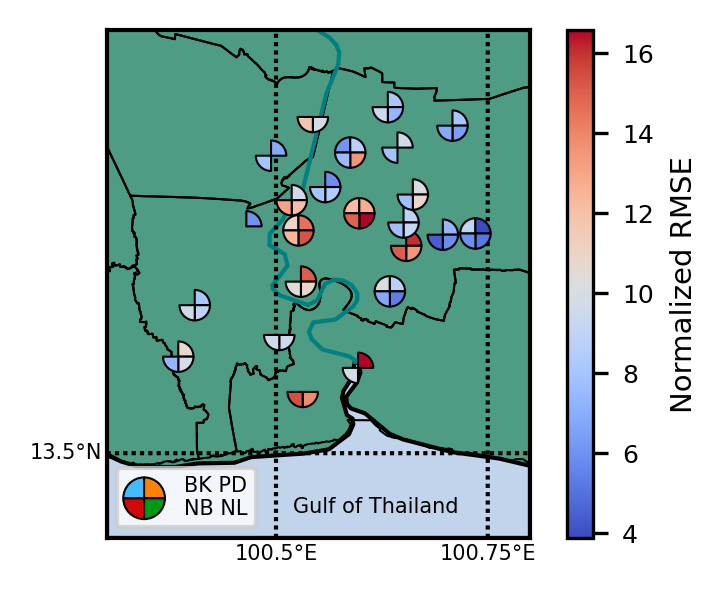

In [5]:
# Importing spatial coordinates
full_path = os.path.join(tot_path, 'GroundwaterWellLocs.xls')
gwwell_locs = pd.read_excel(full_path)

# Locations of wellnests removing duplicates
gwwell_locs = gwwell_locs.drop_duplicates('WellNest_Name', keep='first')

# Aquifer of interest
aqs = ["BK", "PD", "NL", "NB"]

# Preallocation
# Empty dictionary
d_dict = {}

# For each aquifer of interest
for aq in aqs:

    # Preallocation
    # Saving relevant xs, ys, and rmse
    xs = []
    ys = []
    cs = []

    # Subsets of the RMSE data, and list of wellnest names
    well_data = []
    wellnest_list = []

    # Extracting relavent data
    # Going through each rmse saved
    for i in rmse:

        # If string ie if the well nest or aquifer name
        if type(i) == str:

            # If the aquifer anem
            if i.startswith(aq):

                # Saving well nest name, well name, and rmse
                well_data.extend([rmse[rmse.index(i)-1],
                                  rmse[rmse.index(i)],
                                  rmse[rmse.index(i)+1]])
                wellnest_list.extend([rmse[rmse.index(i)-1]])

    # Unique well nests and locations only
    unique = []

    # Getting rid of repeating wells and data points
    # zip joins x and y coordinates in pairs
    for x, y in zip(gwwell_locs.Long, gwwell_locs.Lat):

        # Check if x, y is unique
        if (x, y) not in unique:

            # Saves this location for plotting
            unique.append((x, y))

            # Label is well nest name
            label = gwwell_locs.loc[
                gwwell_locs.Long == x]['WellNest_Name'].tolist()
            # Specific well nest does not have a well in the aquifer
            if label[0] not in wellnest_list:
                continue

            # If well nest has a well in the aquifer
            else:

                # Saving data
                xs.append(x)
                ys.append(y)

                # Relative RMSE multiplied by 100 and saved as %
                cs.append(well_data[well_data.index(label[0])+2]*100)

    # Creates a dictionary with location and relative RMSE value
    d_dict[aq] = pd.DataFrame({"x": xs, "y": ys, "cs": cs})

# Initializing figure
fig, ax = plt.subplots(figsize=(3.2, 2.2), dpi=300)

# Plotting settings
# Setting the same color bar limits for all four wells
# Setting relative RMSE as a percentage; hence multiplying by 100
data_temp = np.multiply([e for e in rmse if isinstance(e, float)], 100)
data_lim = [min(np.array(data_temp)[~mfs.is_outlier(data_temp, 3.5)]),
            max(np.array(data_temp)[~mfs.is_outlier(data_temp, 3.5)])]

plt.set_cmap("coolwarm")  # Color map settings

# Plots
# Creating a basemap
map = Basemap(llcrnrlon=100.3, llcrnrlat=13.4, urcrnrlon=100.8, urcrnrlat=14,
              resolution='h', ellps='WGS84', lat_0=13.6, lon_0=100.4)

bkk_sub_gw.bkk_plotting.draw_basemap(map, xs, ys, d_dict, fig=fig, ax=ax,
                                     datalim=data_lim, mode='RMSE_full', save=0,
                                     aq=aq, perc=0,
                                     time_min=time_min, time_max=time_max,
                                     figpath=fig_path)

if save_graph == 1:

    # Saving figure
    fig_name1 = 'Paper_RMSE_' + time_min + '_' + time_max + '.png'
    full_figpath = os.path.join(fig_path, fig_name1)
    plt.savefig(full_figpath, bbox_inches='tight', format='png')

    fig_name1 = 'Paper_RMSE_' + time_min + '_' + time_max + '.eps'
    full_figpath = os.path.join(fig_path, fig_name1)
    plt.savefig(full_figpath, bbox_inches='tight', format='eps')

## Tmax Plotting
- Output: One spatial plot: 2D plot with color indicator of tmax for all 4 aq
- Figure 9 in _Groundwater_ paper

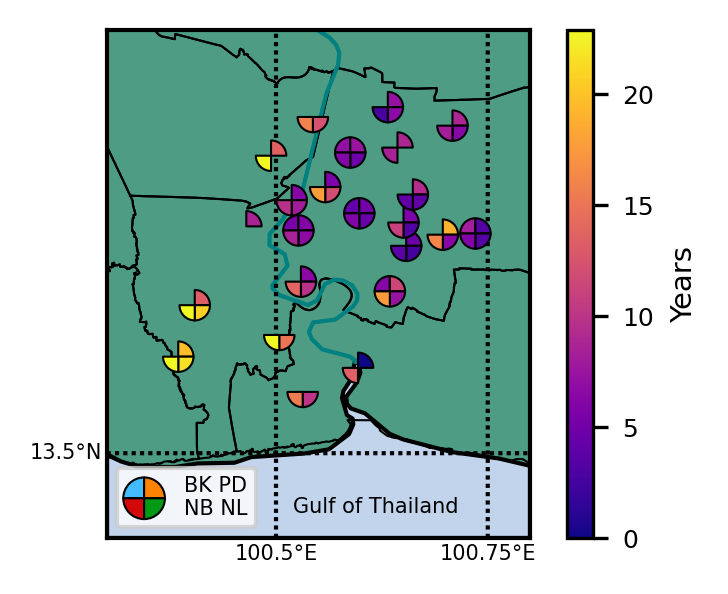

In [6]:
# Importing spatial coordinates
full_path = os.path.join(tot_path, 'GroundwaterWellLocs.xls')
gwwell_locs = pd.read_excel(full_path)

# Locations of wellnests; removing duplicates
gwwell_locs = gwwell_locs.drop_duplicates('WellNest_Name', keep='first')

# Aquifer of interest
aqs = ["BK", "PD", "NL", "NB"]

# Preallocation
# Empty dictionary
d_dict = {}

# Getting data
# For each aquifer of interest
for aq in aqs:

    # Preallocation
    # Saving relevant xs, ys, and tmax
    xs = []
    ys = []
    cs = []

    # Subsets of the res_tmax data, and list of wellnest names
    well_data = []
    wellnest_list = []

    # Extracting relavent data
    # Going through each res_tmax data
    for i in res_tmax:

        # If string (well nest or aquifer name)
        if type(i) == str:

            # If the aquifer name
            if i.startswith(aq):

                # Saving well nest name, well name, and res_tmax
                well_data.extend([res_tmax[res_tmax.index(i)-1],
                                  res_tmax[res_tmax.index(i)],
                                  res_tmax[res_tmax.index(i)+1]])
                wellnest_list.extend([res_tmax[res_tmax.index(i)-1]])

    # Unique x, ys only
    # Dissuades if multiple well nests at the same location
    unique = []

    # Getting rid of repeating wells and data points
    # zip joins x and y coordinates in pairs
    for x, y in zip(gwwell_locs.Long, gwwell_locs.Lat):

        # Check if x, y is unique
        if (x, y) not in unique:

            # Saves location for plotting
            unique.append((x, y))

            # Label is well nest name
            label = gwwell_locs.loc[
                gwwell_locs.Long == x]['WellNest_Name'].tolist()

            # Specific well nest does not have a well in the aquifer
            if label[0] not in wellnest_list:
                continue

            # If well nest has a well in the aquifer
            else:

                # Saving data
                xs.append(x)
                ys.append(y)
                cs.append(well_data[well_data.index(label[0])+2])

    # Dictionary with locations and data
    d_dict[aq] = pd.DataFrame({"x": xs, "y": ys, "cs": cs})

# Plot settings
# Initializing figure
fig, ax = plt.subplots(figsize=(3.2, 2.2), dpi=300)

# Setting the same color bar limits for all four wells
data_temp = [e for e in res_tmax if isinstance(e, float)]
data_lim = [min(np.array(data_temp)[~mfs.is_outlier(data_temp, 3.5)]),
            max(np.array(data_temp)[~mfs.is_outlier(data_temp, 3.5)])]

plt.set_cmap("plasma")  # Color map colors

# Plots
map = Basemap(llcrnrlon=100.3, llcrnrlat=13.4, urcrnrlon=100.8, urcrnrlat=14,
              resolution='h', ellps='WGS84', lat_0=13.6, lon_0=100.4)
bkk_sub_gw.bkk_plotting.draw_basemap(map, xs, ys, d_dict, fig=fig, ax=ax,
                                     datalim=data_lim, mode='step_full', save=0,
                                     aq=aq, perc=0,
                                     time_min=time_min, time_max=time_max,
                                     figpath=fig_path)